In [ ]:
import sys
sys.path.append(r"C:/Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence/")

from utils import load_hdf5, parse_parameters
from analysis import measure, compute_xhi_mean
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import pymc as pm
import arviz as az

In [13]:
file = r"./out/long/SITH_E3O2P21R12T17_Reload_L10_C750_S75_T0.25_10000000.h5"
parameters = parse_parameters("./parameters.yaml")
inter = parameters["Number of interaction"] * 2
n = parameters["Community size"]
t, l = load_hdf5(file)
print("Number of interaction: ", inter)
print("Asymmetry rate: ", measure("Asymmetry", t, l, parameters))
print("Individual asymmetry rate: ", measure("Individual asymmetry", t, l, parameters))
print("Out preserving ind. asymmetry: ", measure("Individual asymmetry", t, l, parameters, random=True, niter=1000, mode="o"))
print("Saturation rate: ", measure("Saturation rate", t, l, parameters))
link_stat = measure("Number of link", t, l, parameters)
print("Mean number of link per agent: ", link_stat[0])
print("Standard deviation number of link per agent: ", link_stat[1])
print("Mean number of interaction per link: ", 2 * inter / (n * (n-1)))

Number of interaction:  10000000
Asymmetry rate:  0.6242476354256233
Individual asymmetry rate:  0.4166666666666667
Out preserving ind. asymmetry:  0.7142857142857143
Saturation rate:  0.8266666666666667
Mean number of link per agent:  21.333333333333332
Standard deviation number of link per agent:  55.647701360134064
Mean number of interaction per link:  3603.6036036036035


Estimated eta:  6.419239786766595


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_1440\2716832538.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi(t)$")


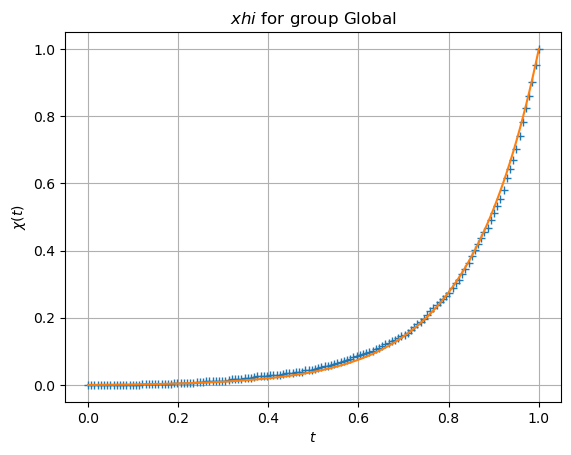

In [8]:
selector = "Global"
xhi_mean = compute_xhi_mean(t, parameters, ph_selector=selector)
size = xhi_mean.size
t_norm = np.arange(size)/(size-1)
model = lambda i, eta:  (np.exp(eta * i) - 1) / (np.exp(eta) - 1)
popt, copt = curve_fit(model, t_norm, xhi_mean)
print("Estimated eta: ", popt[0])
plt.plot(t_norm, xhi_mean, "+", label="data")
plt.plot(t_norm, model(t_norm, popt[0]), label="model")
plt.xlabel("$t$")
plt.ylabel("$\chi(t)$")
plt.title("$xhi$ for group {}".format(selector))
plt.grid()
plt.show()

In [12]:
xhi_mean = compute_xhi_mean(t, parameters)
size = xhi_mean.size
t_norm = np.arange(size) / (size-1)
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    etas = pm.Normal("etas", mu=2.5, sigma=4)

    # Likelihood
    likelihood = pm.Normal("xhi mean", mu= (np.exp(etas * t_norm) - 1) / (np.exp(etas) - 1), sigma=sigma, observed=xhi_mean)

    # Inference
    idata = pm.sample(3000, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, etas]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.


In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
etas,9.919,0.083,9.756,10.070,0.001,0.001,12288.0,8707.0,1.0
sigma,0.018,0.001,0.016,0.019,0.000,0.000,12043.0,8707.0,1.0


In [14]:
pp = pm.sample_posterior_predictive(idata, model, progressbar=False)
idata.extend(pp)

Sampling: [xhi mean]


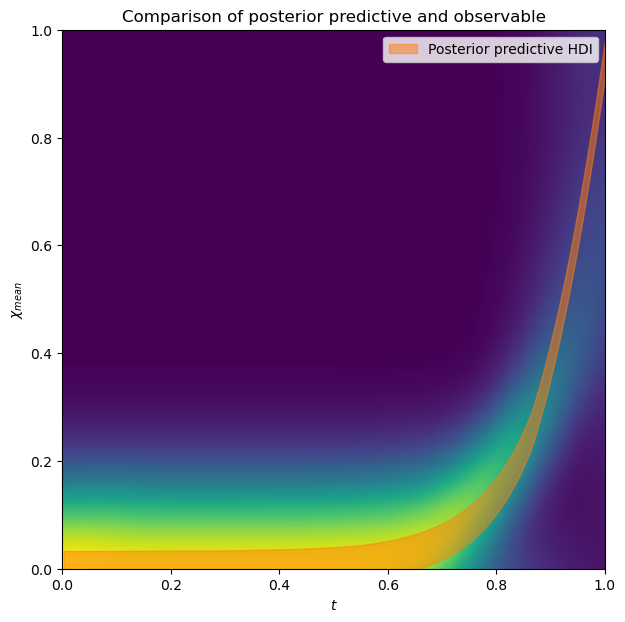

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
az.plot_kde(t_norm, xhi_mean, contour=False, ax=ax, label="Observed data KDE", fill_kwargs={"alpha": 0.1})
az.plot_hdi(t_norm, idata.posterior_predictive["xhi mean"], fill_kwargs={"label": "Posterior predictive HDI"})
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xlabel("$t$")
ax.set_ylabel("$\\chi_{mean}$")
ax.set_title("Comparison of posterior predictive and observable")
plt.legend()
plt.show()